In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize

import sklearn

In [18]:
import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest

from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
df = pd.read_csv('../data/master_df_1.csv')
api = pd.read_csv('../data/api_data.csv')

In [20]:
df.head()

,imdb_id,title,overviews,join_director,join_cast,vote_average,vote_count,genre,user_plots,synopsis
0,tt0111161,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,FrankDarabont,TimRobbins MorganFreeman BobGunton,8.7,18845,Drama,['Two imprisoned men bond over a number of yea...,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,tt0068646,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",FrancisFordCoppola,AlPacino MarlonBrando JamesCaan,8.7,14225,Crime Drama,"[""An organized crime dynasty's aging patriarch...","In late summer 1945, guests are gathered for t..."
2,tt0468569,The Dark Knight,Batman raises the stakes in his war on crime. ...,ChristopherNolan,ChristianBale HeathLedger MichaelCaine,8.5,24993,Action Crime Drama,['When the menace known as the Joker wreaks ha...,The movie begins with a gang of men with clown...
3,tt0071562,The Godfather: Part II,In the continuing saga of the Corleone crime f...,FrancisFordCoppola,AlPacino RobertDeNiro RobertDuvall,8.6,8488,Crime Drama,['The early life and career of Vito Corleone i...,The Godfather Part II presents two parallel st...
4,tt0050083,12 Angry Men,The defense and the prosecution have rested an...,SidneyLumet,MartinBalsam JohnFiedler LeeJ.Cobb,8.5,5539,Crime Drama,['A jury holdout attempts to prevent a miscarr...,"In a New York City courthouse, an eighteen-yea..."


## Creating Individual Genre Columns

In [21]:
#creating column for first genere that appears in the existing genre column

main_genre = [g.split(' ')[0] for g in df['genre']]
df['main_genre'] = main_genre

In [22]:
df['main_genre'].value_counts(normalize=True)

Comedy       0.277210
Action       0.240529
Drama        0.168070
Crime        0.071708
Biography    0.059230
Adventure    0.059080
Animation    0.053518
Horror       0.052315
Fantasy      0.006314
Mystery      0.004059
Thriller     0.002556
Western      0.001353
Family       0.001052
Sci-Fi       0.001052
Romance      0.000902
Film-Noir    0.000752
Music        0.000150
Musical      0.000150
Name: main_genre, dtype: float64

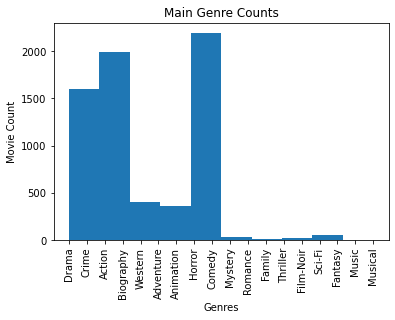

In [23]:
import matplotlib.pyplot as plt

plt.hist(df['main_genre'])
plt.xticks(rotation='vertical')
plt.title('Main Genre Counts')
plt.xlabel('Genres')
plt.ylabel('Movie Count');

Genre classes are severely unbalanced as only the first genre that appears in the 'genre' column is being considered.  

'The Shining' is a 'Horror' but also a 'Drama', however it only appears in the 'Drama' column, as 'Drama' was the first genre that appeared in the original genre column. 

In [24]:
#creating function to make a new column for each genre
#1 = if the genre appears anywhere in the original genre column
#0 = if the genre does not appear anywhere in the original genre column

def create_general_genre(specific_genre):
    genre = []
    for genres in df['genre']:
        if specific_genre in genres:
            genre.append(1)
        else:
            genre.append(0)
    
    df[specific_genre] = genre
    
    return df[specific_genre].value_counts(normalize=True).sort_index()[1]

In [25]:
general_genres = ['Comedy', 'Action', 'Drama', 'Crime', 'Biography', 'Adventure', 'Animation', 'Horror',
                 'Fantasy', 'Mystery', 'Thriller', 'Western', 'Family', 'Sci-Fi', 'Romance', 'Film-Noir',
                 'Musical', 'Music']

In [26]:
#apply the function to create general genre columns
for genre in general_genres:
    create_general_genre(genre)

In [27]:
general_genres = ['Comedy', 'Action', 'Drama', 'Crime', 'Biography', 'Adventure', 'Animation', 'Horror',
                 'Fantasy', 'Mystery', 'Thriller', 'Western', 'Family', 'Sci-Fi', 'Romance', 'Film-Noir',
                 'Musical', 'Music']

genre_dict = {}

for genre in general_genres:
    genre_dict[genre] = df[genre].value_counts().sort_index()[1]

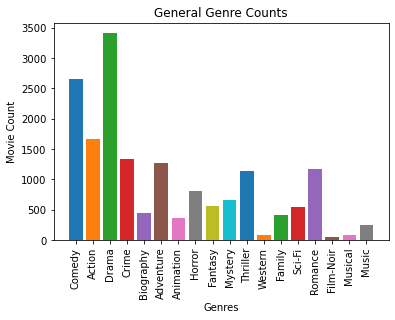

In [28]:
for genre in genre_dict:
    plt.bar(genre, genre_dict[genre]);
plt.xticks(rotation='vertical')
plt.xlabel('Genres')
plt.ylabel('Movie Count')
plt.title('General Genre Counts');

In [29]:
movie_count  = 0
for genre in genre_dict:
    movie_count += genre_dict[genre]
movie_count

16891

The general genre columns displays all the movies with each specific genre appearing at least once in the 'genre' column. The total count for all the movies is now 16,891 meaning some movies appear in multiple genres. This will allow for cross-functional movie reccomendations. For example, 'The Shining' is a 'Horror' but also a 'Drama', so it appears in both columns. 

The original genre column was too specific, with over 383 unqiue genres like 'Comedy Drama Romance' and 'Animation Adventure Family', these unique genres are too specific for my relatively small data set. They are also bias to the order of the genres, for example, 'Crime Drama' != 'Drama Crime'. 

The 'main_genre' column is also too specific, where every movie only appears once and is bound to the first genre that appeared in the original_genre column.

The general_genre columns are a good balance, with each movie appearing in all genre columns that appear in the original genre column

## Creating Genre DF's

In [214]:
general_genres = ['Comedy', 'Action', 'Drama', 'Crime', 'Biography', 'Adventure', 'Animation', 'Horror',
                 'Fantasy', 'Mystery', 'Thriller', 'Western', 'Family', 'Sci-Fi', 'Romance', 'Film-Noir',
                 'Musical', 'Music']

In [281]:
#creating a new dataframe for each general_genre for movies that have a 1 in that column

comedy = df.loc[df['Comedy'] == 1]
comedy.reset_index(inplace=True)

action = df.loc[df['Action'] == 1]
action.reset_index(inplace=True)

drama = df.loc[df['Drama'] == 1]
drama.reset_index(inplace=True)

crime = df.loc[df['Crime'] == 1]
crime.reset_index(inplace=True)

biography = df.loc[df['Biography'] == 1]
biography.reset_index(inplace=True)

adventure = df.loc[df['Adventure'] == 1]
adventure.reset_index(inplace=True)

animation = df.loc[df['Animation'] == 1]
animation.reset_index(inplace=True)

horror = df.loc[df['Horror'] == 1]
horror.reset_index(inplace=True)

fantasy = df.loc[df['Fantasy'] == 1]
fantasy.reset_index(inplace=True)

mystery = df.loc[df['Mystery'] == 1]
mystery.reset_index(inplace=True)

thriller = df.loc[df['Thriller'] == 1]
thriller.reset_index(inplace=True)

western = df.loc[df['Western'] == 1]
western.reset_index(inplace=True)

family = df.loc[df['Family'] == 1]
family.reset_index(inplace=True)

scifi = df.loc[df['Sci-Fi'] == 1]
scifi.reset_index(inplace=True)

romance = df.loc[df['Romance'] == 1]
romance.reset_index(inplace=True)

noir = df.loc[df['Film-Noir'] == 1]
noir.reset_index(inplace=True)

musical = df.loc[df['Musical'] == 1]
musical.reset_index(inplace=True)

music = df.loc[df['Music'] == 1]
music.reset_index(inplace=True)

In [284]:
genre_dfs = [comedy, action, drama, crime, biography, adventure, animation, horror, fantasy, 
             mystery, thriller, western, family, scifi, romance, noir, musical, music]

In [287]:
movie_count = 0
for df in genre_dfs:
    movie_count += df.shape[0]
movie_count

16891

## Saving Genre DF's

In [2]:
comedy.to_csv('../data/genre_groups/comedy.csv', index=False)
action.to_csv('../data/genre_groups/action.csv', index=False)
drama.to_csv('../data/genre_groups/drama.csv', index=False)
crime.to_csv('../data/genre_groups/crime.csv', index=False)
biography.to_csv('../data/genre_groups/biography.csv', index=False)
adventure.to_csv('../data/genre_groups/adventure.csv', index=False)
animation.to_csv('../data/genre_groups/animation.csv', index=False)
horror.to_csv('../data/genre_groups/horror.csv', index=False)
fantasy.to_csv('../data/genre_groups/fantasy.csv', index=False)
mystery.to_csv('../data/genre_groups/mystery.csv', index=False)
thriller.to_csv('../data/genre_groups/thriller.csv', index=False)
western.to_csv('../data/genre_groups/western.csv', index=False)
family.to_csv('../data/genre_groups/family.csv', index=False)
scifi.to_csv('../data/genre_groups/scifi.csv', index=False)
romance.to_csv('../data/genre_groups/romance.csv', index=False)
noir.to_csv('../data/genre_groups/noir.csv', index=False)
musical.to_csv('../data/genre_groups/musical.csv', index=False)
music.to_csv('../data/genre_groups/music.csv', index=False)

NameError: name 'comedy' is not defined

## Saving Master Genre DF

In [32]:
df.to_csv('../data/genre_groups/master_genre_df.csv', index=False)

# Testing Basic Genre Model 

In [4]:
comedy = pd.read_csv('../data/genre_groups/comedy.csv')

In [5]:
test = comedy['user_plots']

In [6]:
test[0]

'[\'Marty McFly, a 17-year-old high school student, is accidentally sent thirty years into the past in a time-traveling DeLorean invented by his close friend, the eccentric scientist Doc Brown.\', \'Marty McFly, a typical American teenager of the Eighties, is accidentally sent back to 1955 in a plutonium-powered DeLorean "time machine" invented by a slightly mad scientist. During his often hysterical, always amazing trip back in time, Marty must make certain his teenage parents-to-be meet and fall in love - so he can get back to the future.\', \'Marty McFly\\\'s life is a dump. His father, George, is constantly bullied by his supervisor Biff Tannen and his mother, Lorraine, is an overweight alcoholic. One day, Marty gets a call from his scientist friend Dr. "Doc" Emmet Brown telling Marty to meet him at Twin Pines Mall at 1:15 AM where Doc unveils a time machine that runs off of plutonium built into a DeLorean and demonstrates it to Marty. Marty accidentally activates the time machine,

In [7]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')
matrix = tf.fit_transform(test)

In [8]:
matrix.shape

(2652, 364868)

In [9]:
cos = sklearn.metrics.pairwise.linear_kernel(matrix, matrix)
cos = [row for row in cos]
cos_df = pd.DataFrame(cos)
cos_df['title'] = comedy['title']

In [10]:
title = [x for x in cos_df['title']]
cos_df.set_index('title', inplace=True)
cos_df.columns = [x for x in cos_df.index]

In [11]:
def recommend_me(title):
    l = cos_df[title]
    return l.sort_values(ascending=False)[1:10]

In [35]:
recommend_me('Back to the Future')

title
Back to the Future Part III           0.565937
Back to the Future Part II            0.483751
Big Fat Liar                          0.153957
Seven Psychopaths                     0.115808
Last Flag Flying                      0.113928
The Campaign                          0.101167
Inherent Vice                         0.094116
Madagascar                            0.086176
Madagascar 3: Europe's Most Wanted    0.077993
Name: Back to the Future, dtype: float64